In [1]:
import tensorflow as tf
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import math
from math import pi
from scipy.stats import norm
## %matplotlib inline

In [2]:
np.random.seed(42)
x = np.random.normal(size=1000)
np.max(x)

3.8527314906547212

In [5]:
## Script adjusted from https://stackoverflow.com/questions/18320240/animate-a-histogram-in-python

def animate_hist(x, n_bins, number_steps=10, update_frequency=200):
    
    def step():
        for step in range(number_steps + 1):
            x_size = round(len(x) / (number_steps) * (step + 1))
            density, edges = np.histogram(x[:x_size], bins=bins, density=True)
            #print(density)
            yield x_size, density
            
    def animate(arg, ax, rects):
        x_size, frequences = arg
        for rect, f in zip(rects, frequences):
            rect.set_height(f)
        ax.set_title('Sample size ' + str(x_size))
            
    def plot_normal(ax, mean, sigma, from_x, to_x, resolution=100):
        relevant_x = np.linspace(from_x, to_x, resolution)
        x_pdf = norm.pdf(relevant_x, loc=mean, scale=sigma)
        ax.plot(relevant_x * n_bins / to_x / 2 + n_bins / 2 - 0.5 , x_pdf)
    
    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    pos = np.arange(n_bins + 1)
    width = 1.0
    
    frequencies = [0. for _ in range(n_bins + 1)]
    border = round(max(abs(min(x)), max(x)))
    bins = np.linspace(-border, border, n_bins + 1)

    ax.set_xticks(pos - (width / 2))
    ax.set_xticklabels(bins)
    
    ax.set_ylim([0., 0.6])
    
    rects = plt.bar(pos, frequencies, width, color='r')
    
    plot_normal(ax, 0, 1, -4, 4)
    
    return FuncAnimation(fig, animate, step, interval=update_frequency, repeat=False, blit=False, fargs=(ax, rects,))

ani = animate_hist(x, 16, 75, update_frequency=100)
ani.save('increasing_sample_histogram.mp4')

In [7]:
def animate_normal_approximation(x, number_steps=10, update_frequency=200):
    
    def step():
        for step in range(number_steps + 1):
            x_size = round(len(x) / (number_steps) * (step + 1))
            mu, sigma = find_mu_sigma(x[:x_size])
            yield x_size, mu, sigma
            
    def animate(arg, ax, approx_normal):
        x_size, mu, sigma = arg
        ax.set_title('Sample size ' + str(x_size))
        approx_normal.set_ydata(plot_normal(mu, sigma, -4, 4)[1])
    
    def plot_normal(mean, sigma, from_x, to_x, resolution=100):
        relevant_x = np.linspace(from_x, to_x, resolution)
        x_pdf = norm.pdf(relevant_x, loc=mean, scale=sigma)
        return relevant_x, x_pdf
        #ax.plot(relevant_x, x_pdf)
        
    def find_mu_sigma(x):
        mu = np.mean(x)
        sigma = np.sqrt(sum(np.square(x - mu)) / (x.shape[0] - 1))
        return mu, sigma

    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    
    #border = round(max(abs(min(x)), max(x)))
    ax.set_xlim([-4, 4])
    ax.set_ylim([0., 0.5])

    rel_x, rel_y = plot_normal(0, 1, -4, 4)
    real_normal = ax.plot(rel_x, rel_y)    
    approx_normal = ax.plot(rel_x, rel_y, 'r')
    
    return FuncAnimation(fig, animate, step, interval=update_frequency, repeat=False, blit=False, fargs=(ax, approx_normal[0],))
    
ani = animate_normal_approximation(x[:300], number_steps=75, update_frequency=100)
ani.save('approxim_normal.mp4')

In [23]:
import math

def animate_normal_fitting(x, start_mu, start_sigma, number_steps=10, update_frequency=200):
    
    def step():
        for step in range(number_steps + 1):
            mu = 0.95 ** step * 2 - 2 
            sigma = start_sigma * 0.978 ** step 
            yield mu, sigma
            
    def animate(arg, ax, approx_normal):
        mu, sigma = arg
        likelihood = norm.pdf(x, loc=mu, scale=sigma)
        ax.set_title('Likelihood: ' + str(likelihood))
        approx_normal.set_ydata(plot_normal(mu, sigma, -4, 4)[1])
    
    def plot_normal(mean, sigma, from_x, to_x, resolution=100):
        relevant_x = np.linspace(from_x, to_x, resolution)
        x_pdf = norm.pdf(relevant_x, loc=mean, scale=sigma)
        return relevant_x, x_pdf
        #ax.plot(relevant_x, x_pdf)

    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    
    #border = round(max(abs(min(x)), max(x)))
    ax.set_xlim([-4, 4])
    ax.set_ylim([0., 1.])

    rel_x, rel_y = plot_normal(0, 1, -4, 4)
    target_line = ax.plot([x, x], [0, 1.], 'b')    
    approx_normal = ax.plot(rel_x, rel_y, 'r')
    
    return FuncAnimation(fig, animate, step, interval=update_frequency, repeat=False, blit=False, fargs=(ax, approx_normal[0],))
    
ani = animate_normal_fitting(-2, 0, 2, number_steps=75, update_frequency=50)
ani.save('normal_fitting.mp4')

In [12]:
step = 25
0.85 ** step * 2 - 2

-1.9656043802955843

In [57]:
def animate_kernel_sigma(x, from_sigma, to_sigma, number_steps=10, update_frequency=200, resolution=1000):
    
    def plot_normal(mean, sigma, relevant_x):
        return norm.pdf(relevant_x, loc=mean, scale=sigma)
        #return x_pdf
    
    def step():
        for step in range(number_steps + 1):
            sigma = sigmas[step]
            kernels = [plot_normal(x_i, sigma, relevant_x) / len(x) for x_i in x]
            total_density = np.sum(np.array(kernels), axis=0)
            yield step, sigma, kernels, total_density
            
    def animate(arg, ax, kernel_plots, total_density_plot):
        step, sigma, kernels, total_density = arg
        ax.set_title('Sigma ' + str(sigma))
        for kernel_plot, kernel in zip(kernel_plots, kernels):
            kernel_plot[0].set_ydata(kernel)
        total_density_plot[0].set_ydata(total_density)

    fig, ax = plt.subplots()
    fig.set_tight_layout(True)

    sigmas = np.linspace(from_sigma, to_sigma, number_steps + 1)
    relevant_x = np.linspace(-4, 4, resolution)
    kernels = [plot_normal(x_i, from_sigma, relevant_x) / len(x) for x_i in x]
    kernel_plots = []
    for kernel in kernels:
        kernel_plots.append(ax.plot(relevant_x, kernel, 'b'))
    #print(kernel_plots)
    total_density = np.sum(np.array(kernels), axis=0)
    total_density_plot = ax.plot(relevant_x, total_density, 'r')
    
    return FuncAnimation(fig, animate, step, interval=update_frequency, repeat=False, blit=False, fargs=(ax, kernel_plots, total_density_plot))
    
    #print(total_density.shape)
    
    #plt.show()
    
ani = animate_kernel_sigma(x[:25], 0.06, 0.75, number_steps=140, update_frequency=100)

In [38]:
def shift_weight_kernel(x, focus_index, sigma, number_steps=10, update_frequency=200, resolution=1000):
    
    def plot_normal(mean, sigma, relevant_x):
        return norm.pdf(relevant_x, loc=mean, scale=sigma)
        #return x_pdf
    
    def step():
        for step in range(1, number_steps + 1):
            focus_weight = 1/len(x) + (len(x) - 1) / (len(x)) * (step / (number_steps + 1))
            print(focus_weight)
            non_focus_weight = (1 - focus_weight) / (len(x) - 1)
            kernels = [plot_normal(x_i, sigma, relevant_x) * non_focus_weight for x_i in x]
            kernels[focus_index] = kernels[focus_index] / non_focus_weight * focus_weight
            total_density = np.sum(np.array(kernels), axis=0)
            yield step, focus_weight, kernels, total_density
            
    def animate(arg, ax, kernel_plots, total_density_plot):
        step, focus_weight, kernels, total_density = arg
        ax.set_title('Fraction weight ' + str(focus_weight))
        for kernel_plot, kernel in zip(kernel_plots, kernels):
            kernel_plot[0].set_ydata(kernel)
        total_density_plot[0].set_ydata(total_density)

    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    
    ax.set_ylim([0., 1.0])

    #sigmas = np.linspace(from_sigma, to_sigma, number_steps + 1)
    relevant_x = np.linspace(-4, 4, resolution)
    kernels = [plot_normal(x_i, sigma, relevant_x) / len(x) for x_i in x]
    kernel_plots = []
    for kernel in kernels:
        kernel_plots.append(ax.plot(relevant_x, kernel, 'b'))
    #print(kernel_plots)
    total_density = np.sum(np.array(kernels), axis=0)
    total_density_plot = ax.plot(relevant_x, total_density, 'r')
    
    return FuncAnimation(fig, animate, step, interval=update_frequency, repeat=False, blit=False, fargs=(ax, kernel_plots, total_density_plot))
    
    #print(total_density.shape)
    
    #plt.show()
    
ani = shift_weight_kernel(x[:25], 2, 0.5, number_steps=75, update_frequency=100)

In [ ]:
def shift_weights_widths(x, sigmas, number_steps=10, update_frequency=200, resolution=1000):
    
    def plot_normal(mean, sigma, relevant_x):
        return norm.pdf(relevant_x, loc=mean, scale=sigma)
        #return x_pdf
    
    def step():
        for step in range(1, number_steps + 1):
            focus_weight = 1/len(x) + (len(x) - 1) / (len(x)) * (step / (number_steps + 1))
            print(focus_weight)
            non_focus_weight = (1 - focus_weight) / (len(x) - 1)
            kernels = [plot_normal(x_i, sigma, relevant_x) * non_focus_weight for x_i in x]
            kernels[focus_index] = kernels[focus_index] / non_focus_weight * focus_weight
            total_density = np.sum(np.array(kernels), axis=0)
            yield step, focus_weight, kernels, total_density
            
    def animate(arg, ax, kernel_plots, total_density_plot):
        step, focus_weight, kernels, total_density = arg
        ax.set_title('Fraction weight ' + str(focus_weight))
        for kernel_plot, kernel in zip(kernel_plots, kernels):
            kernel_plot[0].set_ydata(kernel)
        total_density_plot[0].set_ydata(total_density)

    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    
    ax.set_ylim([0., 1.0])

    #sigmas = np.linspace(from_sigma, to_sigma, number_steps + 1)
    relevant_x = np.linspace(-4, 4, resolution)
    kernels = [plot_normal(x_i, s, relevant_x) / len(sigmas) for s in sigmas]
    kernel_plots = []
    for kernel in kernels:
        kernel_plots.append(ax.plot(relevant_x, kernel, 'b'))
    #print(kernel_plots)
    total_density = np.sum(np.array(kernels), axis=0)
    total_density_plot = ax.plot(relevant_x, total_density, 'r')
    
    return FuncAnimation(fig, animate, step, interval=update_frequency, repeat=False, blit=False, fargs=(ax, kernel_plots, total_density_plot))
    
    #print(total_density.shape)
    
    #plt.show()
    
ani = shift_weight_kernel(x[:25], 2, 0.5, number_steps=75, update_frequency=100)

In [68]:
def shift_weights_widths_one_center(x, sigmas, number_steps=10, update_frequency=200, resolution=1000):
    
    def plot_normal(mean, sigma, relevant_x):
        return norm.pdf(relevant_x, loc=mean, scale=sigma)
        #return x_pdf
    
    def step():
        for step in range(1, number_steps + 1):
            a = step / (number_steps + 1) * -2 + 1.6
            #weights = np.exp(arange(len(sigmas)) * a + 1)
            weights = np.exp(np.arange(len(sigmas)) * a) / np.sum(np.exp(np.arange(len(sigmas)) * a))
            #focus_weight = 1/len(sigmas) + (len(sigmas) - 1) / (len(sigmas)) * (step / (number_steps * 2 + 1))
            #non_focus_weight = (1 - focus_weight) / (len(sigmas) - 1)
            #print(focus_weight, non_focus_weight * 4)
            kernels = [plot_normal(0., sigma, relevant_x) * weight for sigma, weight in zip(sigmas, weights)]
            #kernels[focus_index] = kernels[focus_index] / non_focus_weight * focus_weight
            total_density = np.sum(np.array(kernels), axis=0)
            #print(sum(total_density))
            yield step, weights, kernels, total_density
            
    def animate(arg, ax, kernel_plots, total_density_plot):
        step, focus_weight, kernels, total_density = arg
        ax.set_title('Weights ' + str(focus_weight))
        for kernel_plot, kernel in zip(kernel_plots, kernels):
            kernel_plot[0].set_ydata(kernel)
        total_density_plot[0].set_ydata(total_density)

    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    
    ax.set_ylim([0., 2.0])
    
    focus_index = 0

    #sigmas = np.linspace(from_sigma, to_sigma, number_steps + 1)
    relevant_x = np.linspace(-4, 4, resolution)
    kernels = [plot_normal(0., s, relevant_x) / len(sigmas) for s in sigmas]
    kernel_plots = []
    for kernel in kernels:
        kernel_plots.append(ax.plot(relevant_x, kernel, 'b'))
    #print(kernel_plots)
    total_density = np.sum(np.array(kernels), axis=0)
    total_density_plot = ax.plot(relevant_x, total_density, 'r')
    
    return FuncAnimation(fig, animate, step, interval=update_frequency, repeat=False, blit=False, fargs=(ax, kernel_plots, total_density_plot))
    
    #print(total_density.shape)
    
    #plt.show()
    
ani = shift_weights_widths_one_center(np.array([0.]), [0.1, 0.3, 0.7, 1.3, 2.0], number_steps=75, update_frequency=100)

C:\Users\Jan\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [69]:
ani.save('kernels_shift_one_center.mp4')

In [36]:
def shift_weight_kernel(x, focus_index_1, focus_index_2, sigma, number_steps=10, update_frequency=200, resolution=1000):
    
    def plot_normal(mean, sigma, relevant_x):
        return norm.pdf(relevant_x, loc=mean, scale=sigma)
        #return x_pdf
    
    def step():
        for step in range(1, number_steps + 1):
            focus_weight = 1/len(x) + (len(x) - 2) / (len(x)) * (step / (number_steps + 1)) / 2
            print(focus_weight)
            non_focus_weight = (1 - 2 * focus_weight) / (len(x) - 2)
            kernels = [plot_normal(x_i, sigma, relevant_x) * non_focus_weight for x_i in x]
            kernels[focus_index_1] = kernels[focus_index_1] / non_focus_weight * focus_weight
            kernels[focus_index_2] = kernels[focus_index_2] / non_focus_weight * focus_weight
            total_density = np.sum(np.array(kernels), axis=0)
            yield step, focus_weight, kernels, total_density
            
    def animate(arg, ax, kernel_plots, total_density_plot):
        step, focus_weight, kernels, total_density = arg
        ax.set_title('Fraction weight ' + str(focus_weight * 2))
        for kernel_plot, kernel in zip(kernel_plots, kernels):
            kernel_plot[0].set_ydata(kernel)
        total_density_plot[0].set_ydata(total_density)

    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    
    ax.set_ylim([0., 1.0])

    #sigmas = np.linspace(from_sigma, to_sigma, number_steps + 1)
    relevant_x = np.linspace(-4, 4, resolution)
    kernels = [plot_normal(x_i, sigma, relevant_x) / len(x) for x_i in x]
    kernel_plots = []
    for kernel in kernels:
        kernel_plots.append(ax.plot(relevant_x, kernel, 'b'))
    #print(kernel_plots)
    total_density = np.sum(np.array(kernels), axis=0)
    total_density_plot = ax.plot(relevant_x, total_density, 'r')
    
    return FuncAnimation(fig, animate, step, interval=update_frequency, repeat=False, blit=False, fargs=(ax, kernel_plots, total_density_plot))
    
    #print(total_density.shape)
    
    #plt.show()
    
ani = shift_weight_kernel(x[:25], 1, 3, 0.5, number_steps=75, update_frequency=100)

In [4]:
x[:25]

array([ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337,
       -0.23413696,  1.57921282,  0.76743473, -0.46947439,  0.54256004,
       -0.46341769, -0.46572975,  0.24196227, -1.91328024, -1.72491783,
       -0.56228753, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ,
        1.46564877, -0.2257763 ,  0.0675282 , -1.42474819, -0.54438272])

In [37]:
ani.save('kernels_shift_bimodal.mp4')

0.04605263157894737
0.04605263157894737
0.05210526315789474
0.0581578947368421
0.06421052631578947
0.07026315789473685
0.07631578947368421
0.08236842105263158
0.08842105263157896
0.09447368421052632
0.10052631578947369
0.10657894736842105
0.11263157894736842
0.11868421052631581
0.12473684210526315
0.13078947368421054
0.1368421052631579
0.14289473684210527
0.14894736842105263
0.155
0.16105263157894736
0.16710526315789476
0.17315789473684212
0.1792105263157895
0.18526315789473685
0.19131578947368424
0.1973684210526316
0.20342105263157895
0.2094736842105263
0.2155263157894737
0.22157894736842107
0.22763157894736843
0.2336842105263158
0.2397368421052632
0.24578947368421056
0.25184210526315787
0.25789473684210523
0.26394736842105265
0.27
0.2760526315789474
0.28210526315789475
0.2881578947368421
0.2942105263157895
0.30026315789473684
0.3063157894736842
0.3123684210526316
0.31842105263157894
0.3244736842105263
0.33052631578947367
0.33657894736842103
0.34263157894736845
0.34868421052631576
0.3

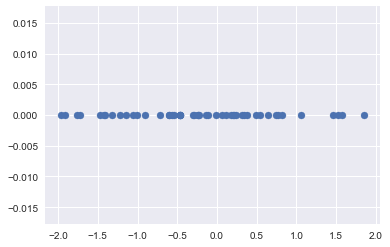

In [33]:
plt.scatter(x, [0 for _ in range(50)])

In [15]:
weights = np.ones_like(x)/float(len(x))
bins = np.arange(-4, 4, 0.4)
n, bins, patches = plt.hist(x, bins=bins, normed=0, weights=weights)
plt.axis([-4, 4, 0., 0.2])

[-4, 4, 0.0, 0.2]

FPS: 1.55


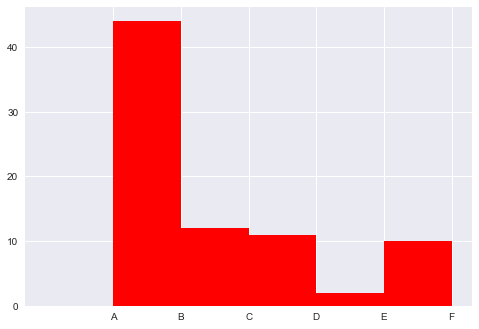

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import timeit

clock = timeit.default_timer

fig, ax = plt.subplots()

alphab = ['A', 'B', 'C', 'D', 'E', 'F']
frequencies = [1, 44, 12, 11, 2, 10]

pos = np.arange(len(alphab))
width = 1.0     # gives histogram aspect to the bar diagram
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(alphab)

rects = plt.bar(pos, frequencies, width, color='r')
start = clock()

def animate(arg, rects):
    frameno, frequencies = arg
    for rect, f in zip(rects, frequencies):
        rect.set_height(f)
    print("FPS: {:.2f}".format(frameno / (clock() - start))) 

def step():
    for frame, bin_idx in enumerate(np.linspace(0,1000000,100000000), 1):
        #Here we just change the first bin, so it increases through the animation.
        frequencies[0] = bin_idx
        yield frame, frequencies


ani = animation.FuncAnimation(fig, animate, step, interval=10,
                              repeat=False, blit=False, fargs=(rects,))
plt.show()


In [25]:
ani.save('test_ani_4.mp4')

In [ ]:
import ffmpeg